# Introduction
Our team has designed a Data Science curriculum for a Master's program from the perspective of job market needs. However, evaluating the courses from students’ perspective is also important for the instructors who will be teaching the new curriculum. This part of the project explores the possibility of using student activity records in an online platform to understand student engagement and interest. Specifically, we use student retention as an indicator for student interest and address the following problem: <br>
**Given a student's activity record on an online learning platform, what can we say about student retention?**

------

# Notebook Overview (by section)

### Dataset: Open University Learning Analytics Dataset (OULAD)
- Dataset description

### Exploratory Data Analysis
- Use visualizations to understand the distribution of the data

### Feature Engineering
- Transform the OULAD studetn activity data into a different representation

### Train-test Split
- 75% for training, 25% for testing

### Handle Data Class Imbalance in the Training Set
- Reduce the bias introduced by class imbalance
 
### Try Different Machine Learning Models
- Find the most well-suited model
- Features: student activity records in week 1
- Target: whether the students will drop the course in week 2 (binary classification)

### Random Forest Hyperparameter Tuning
- Based on the analysis in the last section, Random Forest classifier shows some potential for our classification task. Tune the hyperparameters to improve performance.

### Visualize Feature Importance
- Find out which features are important to the random forest classifier.

### Visualize relationship between homepage activity in week 1 and the target variable
- Based on the analysis in the last section, homepage activity records are important to the random forest classifier. This section visualizes the relationship between homepage activities and the target variable

### Summary of Insights
- Summary of findings presented in this notebook
-------------

# Dataset: Open University Learning Analytics Dataset (OULAD)

"It contains data about courses, students and their interactions with Virtual Learning Environment (VLE) for seven selected courses (called modules). The dataset consists of tables connected using unique identifiers. All tables are stored in the csv format."

More information on the dataset can be found via this link https://analyse.kmi.open.ac.uk/open_dataset#description

In [1]:
import numpy as np
import pandas as pd
import missingno as msno 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# EDA: https://www.kaggle.com/vjcalling/oulad-open-university-learning-analytics-dataset
courses_raw = pd.read_csv("anonymisedData/courses.csv")
student_info_raw = pd.read_csv("anonymisedData/studentInfo.csv")
student_registration_raw = pd.read_csv("anonymisedData/studentRegistration.csv")
vle_raw = pd.read_csv("anonymisedData/vle.csv")
student_vle_raw = pd.read_csv("anonymisedData/studentVle.csv")

In [3]:
# student_info_raw + student_registration_raw --> students 
students = student_info_raw.merge(student_registration_raw, on = ['code_module', 'code_presentation', 'id_student'], how='left')

# vle_raw + student_vle_raw --> student_activity
student_activity = student_vle_raw.merge(vle_raw, on = ['id_site', 'code_module', 'code_presentation'], how = 'left')
student_activity = student_activity.drop(columns = ['week_from','week_to'])

In [4]:
students.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN


In [5]:
student_activity.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type
0,AAA,2013J,28400,546652,-10,4,forumng
1,AAA,2013J,28400,546652,-10,1,forumng
2,AAA,2013J,28400,546652,-10,1,forumng
3,AAA,2013J,28400,546614,-10,11,homepage
4,AAA,2013J,28400,546714,-10,1,oucontent


**Relevant columns from students dataframe**
- **code_module** is the course number
- **code_presentation** is the session the course was offered
- **id_student** is the ID of the student who generated the activity record.
- **final_result** is the students status at the end of the course (withdrawn, fail, pass, distinction)
- **date_unregistration** is the date when the student dropped the course. (date = 0 is the first day of classes)

**Relevant columns from student_activity dataframe**
- **code_module** is the course number
- **code_presentation** is the session the course was offered
- **id_student** is the ID of the student who generated the activity record.
- **date** is the date when the interaction happened. (date = 0 is the first day of classes)
- **sum_click** is the total number of clicks.
- **activity_type** is type of content the student interacted with.

# Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of students across courses')

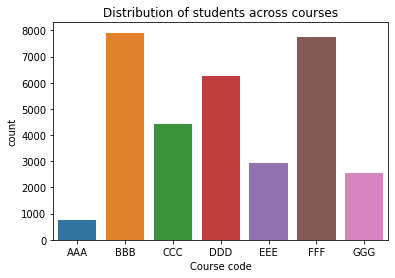

In [7]:
sns.countplot(x ='code_module', data = student_registration_raw)
plt.xlabel('Course code')
plt.title('Distribution of students across courses')

**Observation**: 
- Course AAA has less than 1000 students. This might not be enough to train a generalizable model.

## Distribution of final results for each course

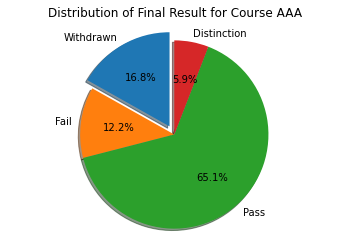

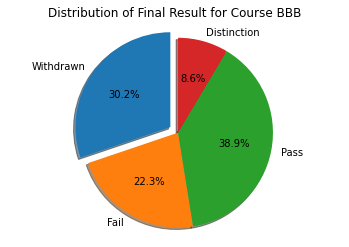

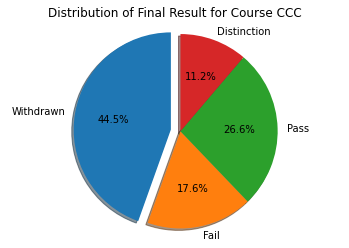

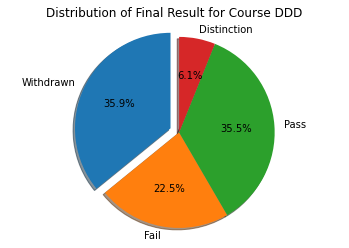

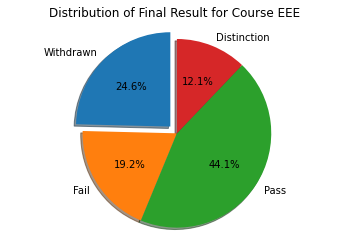

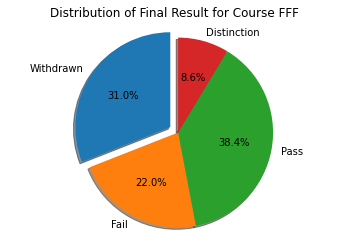

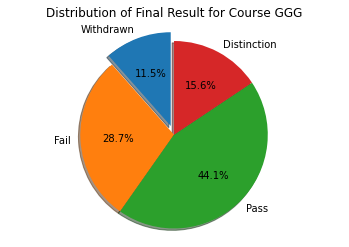

In [8]:
module_codes = ['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG']
for module in module_codes:
    data = student_info_raw[student_info_raw["code_module"]==module]
    
    w = (data['final_result']=='Withdrawn').sum()
    f = (data['final_result']=='Fail').sum()
    p = (data['final_result']=='Pass').sum()
    d = (data['final_result']=='Distinction').sum()
    #total = w+f+p+d
    
    labels = ['Withdrawn', 'Fail', 'Pass', 'Distinction']
    sizes = [w, f, p, d]
    explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.title(str('Distribution of Final Result for Course '+ module))
    
    plt.show()

**Observation:** 
- There is more than 10% of students who withdrew from all of the course. Course CCC had the highest withdrawal rate of 44.5%.

## Distribution of unregistration dates for each course

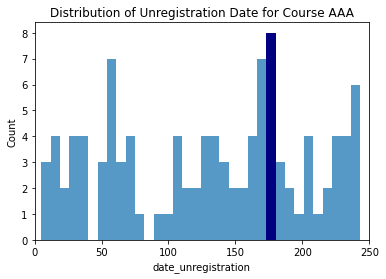

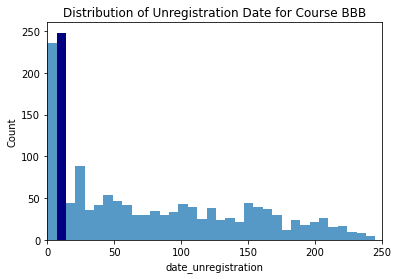

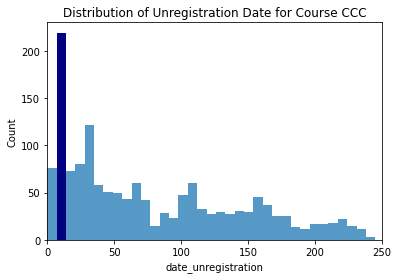

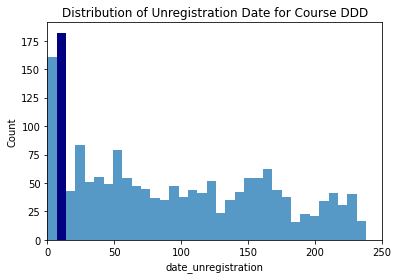

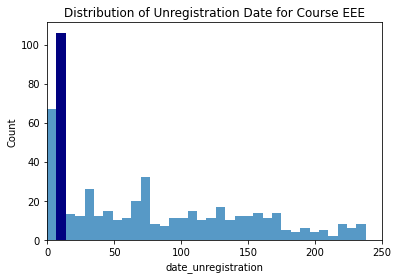

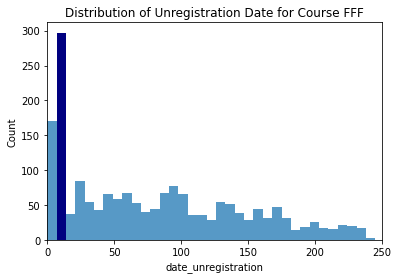

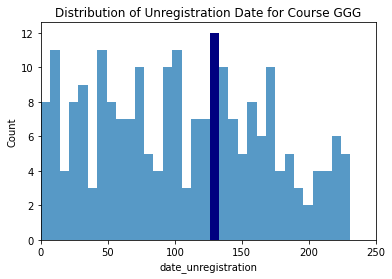

In [9]:
for module in module_codes:
    ax = sns.histplot(
        student_registration_raw[(student_registration_raw["code_module"]==module)& (student_registration_raw["date_unregistration"]>=0)],
        x="date_unregistration",
        #edgecolor=".3",
        linewidth=0,
        binwidth=7
    )
    
    heights = [p.get_height() for p in ax.patches]
    second_highest = sorted(heights)[-2]
    for p in ax.patches:
        if  p.get_height() > second_highest:
            p.set_color('navy')
    plt.xlim([0,250])
    plt.title(str('Distribution of Unregistration Date for Course '+ module))
    plt.show()

**Observations**
- Date 0 corresponds to the first day of classes. The histograms above show the distribution of unregistration dates for those students who dropped after the term began. Note that students who dropped before the term began were not considered in the analysis due to their lack of interaction with the online learing platform.
- For courses BBB, CCC, DDD, EEE, FFF, the week with the highest number of withdrawals is the second week (hightlighted in dark blue in the figures)
- For consistency, we will focus on courses BBB, CCC, DDD, EEE, FFF in our analysis. We will use student activity data in the first week of classes to predict student withdrawal in the second week.

In [10]:
# Re-define module_codes, dropping courses AAA and GGG
module_codes = ['BBB', 'CCC', 'DDD', 'EEE', 'FFF']

# Feature Engineering

The original student_activity data in the dataset need to be transformed into a different form before applying a machine learning algorithm. In the original data, each row contains one activity record, and a student's activity records throughout the term are represented by multiple rows in the original data. In this section of the code, we transform the data so that each row contains all the information and activity records (1st week) for one student.

In the engineered features, each feature represents how much a student interacts with a certain **type** of content on a certain **day** in the first week of classes.

In [11]:
# course codes and sessions
session_codes = [('BBB', '2013B'),('BBB', '2013J'),('BBB', '2014B'),('BBB', '2014J'), ('CCC', '2014B'),
         ('CCC', '2014J'),('DDD', '2013B'),('DDD', '2013J'),('DDD', '2014B'),('DDD', '2014J'),('EEE', '2013J'), ('EEE', '2014B'),('EEE', '2014J'),
         ('FFF', '2013B'),('FFF', '2013J'),('FFF', '2014B'),('FFF', '2014J')]

# activity period of interest
activity_period_start = 0
activity_period_end = 7

# unregistration period of interest
drop_period_start = 7
drop_period_end = 14

# list to store student activity by module/course
student_activity_by_module = []

# IDs of students who dropped before the period we are interested in
early_unregistration_id = students[students['date_unregistration']<drop_period_start].id_student

# filter student_activity data by module/course, unregistration date, and activity period
for module in module_codes:
    frame = student_activity[(student_activity['code_module']==module) & ~(student_activity['id_student'].isin(early_unregistration_id))]
    frame = frame[(frame.date>activity_period_start) & (frame.date<=activity_period_end)]
    student_activity_by_module.append(frame)

In [12]:
# function to define how many days of activity records each feature covers
interval = 1
num_of_intervals = int((activity_period_end-activity_period_start)/interval)
idx = pd.interval_range(start=activity_period_start, end=activity_period_end, freq = interval)

In [13]:
# function to generate the features
def engineer_activity_features(module, student_activity_frame):
    
    # IDs of students who dropped in the second week
    dropped_within_period = students[(students['date_unregistration']<drop_period_end)&(student_registration_raw['date_unregistration']>=drop_period_start)].id_student.values
    
    # get content/activity types, and name the features
    activities = student_activity_frame.activity_type.unique()
    activity_features = [activity+str(i) for activity in activities for i in range(num_of_intervals)]
    engineered_student_activity_columns = ['id_student', 'dropped_in_week_of_interest', *activity_features]
    
    # prepare mask
    student_mask = [False] * students.shape[0]
    
    # filter by module/course
    sessions_to_process= [s for s in session_codes if s[0]==module]
    for module_code, term_code in sessions_to_process:
        student_mask = student_mask | (students['code_module']==module_code)&(students['code_presentation']==term_code)
    
    # filter by students who are in the course and session of interest
    student_list = students[student_mask].id_student.unique()
    df_return = pd.DataFrame(columns=engineered_student_activity_columns)
    
    # loop through each student and extract activity info
    for id_student in student_list :
        records = student_activity_frame[student_activity_frame['id_student']==id_student]
        sum_by_activity_type = {activity: [0]*num_of_intervals for activity in activities} 
        
        # loop through the activity info of a student and generate features
        for index, record in records.iterrows():
            sum_by_activity_type[record.activity_type][idx.get_loc(record.date)] = record.sum_click + sum_by_activity_type[record.activity_type][idx.get_loc(record.date)]
        
        ordered_activity_features = [i for activity in activities for i in sum_by_activity_type[activity]]
            
        new_data = pd.DataFrame([[id_student, id_student in dropped_within_period,*ordered_activity_features]], columns = engineered_student_activity_columns)
        df_return = df_return.append(new_data)
        
    return df_return

In [14]:
student_activity_features =  []

# call the function to generate features for each module/course
for module, module_activity in zip(module_codes, student_activity_by_module) :    
    student_activity_features.append(engineer_activity_features(module, module_activity))

In [15]:
student_activity_features[0].head()

,id_student,dropped_in_week_of_interest,homepage0,homepage1,homepage2,homepage3,homepage4,homepage5,homepage6,forumng0,...,sharedsubpage4,sharedsubpage5,sharedsubpage6,oucollaborate0,oucollaborate1,oucollaborate2,oucollaborate3,oucollaborate4,oucollaborate5,oucollaborate6
0,23629,False,0,2,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,25107,False,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,27891,False,0,0,2,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,29144,False,0,3,2,17,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,31663,False,3,19,7,2,5,4,0,16,...,0,0,0,0,0,0,0,0,0,0


**Interpretation of engineered student activity features**:
- The feature names indicate the activity/content type, followed by the date. 
- For example, "homepage0" is the number of times a student interacted with the homepage (activity/content type) on day 0 (date).

In [57]:
act = student_activity_features[0][student_activity_features[0].dropped_in_week_of_interest == True].sum()
n = student_activity_features[0][student_activity_features[0].dropped_in_week_of_interest == True].shape[0]
act = act.drop(['id_student', 'dropped_in_week_of_interest'])
act.sum()/n

15.188755020080322

In [58]:
act = student_activity_features[0][student_activity_features[0].dropped_in_week_of_interest == False].sum()
n = student_activity_features[0][student_activity_features[0].dropped_in_week_of_interest == False].shape[0]
act = act.drop(['id_student', 'dropped_in_week_of_interest'])
act.sum()/n

38.01961574633884

In [55]:
student_activity_features[0][student_activity_features[0].dropped_in_week_of_interest == True]

,id_student,dropped_in_week_of_interest,homepage0,homepage1,homepage2,homepage3,homepage4,homepage5,homepage6,forumng0,...,sharedsubpage4,sharedsubpage5,sharedsubpage6,oucollaborate0,oucollaborate1,oucollaborate2,oucollaborate3,oucollaborate4,oucollaborate5,oucollaborate6
0,34431,True,0,0,7,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
0,72070,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,155735,True,0,3,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,177639,True,3,0,2,0,0,5,0,10,...,0,0,0,0,0,0,0,0,0,0
0,228049,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2399380,True,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,2464901,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,2603534,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,2614271,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train-test Split

In [16]:
# train-test split. Default percentage of test data is 25%
from sklearn.model_selection import train_test_split
student_activity_features_train = []
student_activity_features_test = []

for module in student_activity_features:
    train, test = train_test_split(module, random_state = 25)
    student_activity_features_train.append(train)
    student_activity_features_test.append(test)

# Handle Data Class Imbalance in the Test Set
The number of students who dropped in the second week is a very small portion of all the students who enrolled, as shown in the graphs below. If we feed the data into machine learning algorithms directly, the algorithm would very likely be biased towards predicting the majority class.

To handle the problem of data imbalance, we use To handle the problem of data imbalance, we use SMOTETomek, a technique that combines oversampling and undersampling to re-sample the minority class. 

SMOTETomek documentation: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTETomek.html

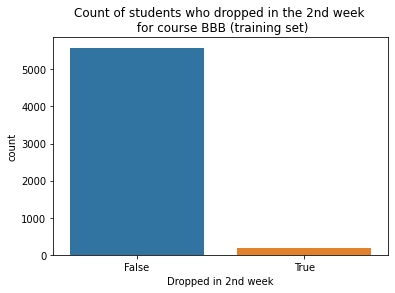

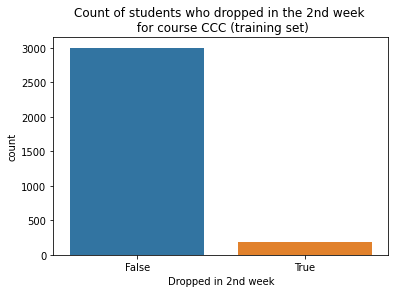

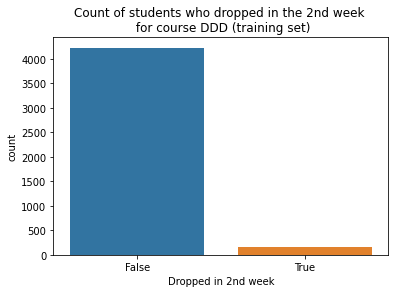

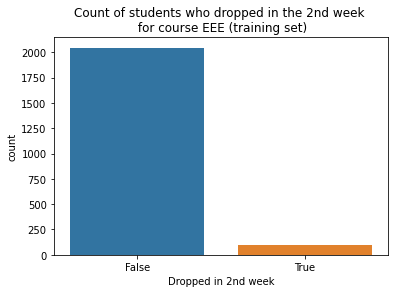

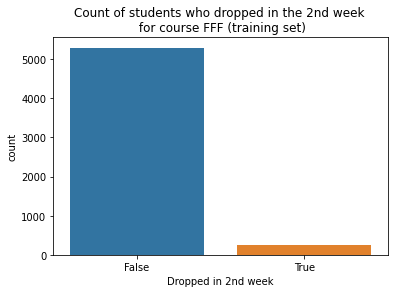

In [17]:
for module, code in zip(student_activity_features_train, module_codes):
    sns.countplot(x='dropped_in_week_of_interest', data=module)
    plt.title(str('Count of students who dropped in the 2nd week \n for course ' + code + ' (training set)'))
    plt.xlabel('Dropped in 2nd week')
    plt.show()

In [18]:
# https://github.com/krishnaik06/Handle-Imbalanced-Dataset/blob/master/Handling%20Imbalanced%20Data-%20Over%20Sampling.ipynb
# https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=42)

resampled_xy_train = []
for module in student_activity_features_train:    
    X = module.drop(columns = ['id_student','dropped_in_week_of_interest']).reset_index(drop = True)
    Y = module['dropped_in_week_of_interest'].reset_index(drop = True).astype('bool')
    
    X_res,y_res= smk.fit_sample(X,Y)
    resampled_xy_train.append([X_res,y_res])

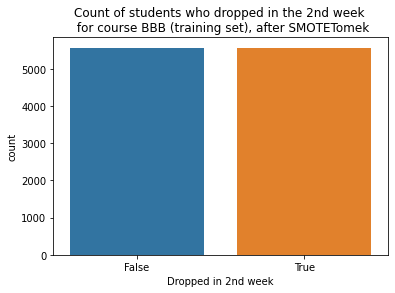

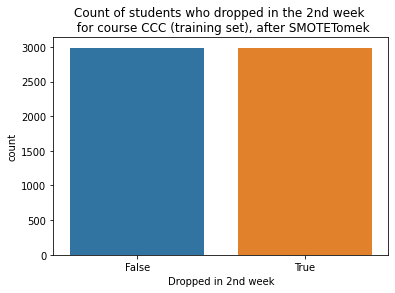

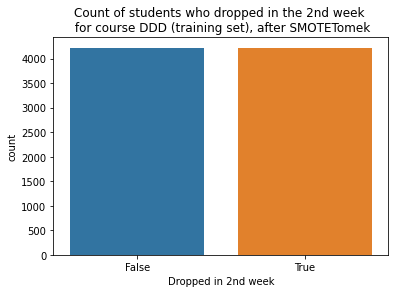

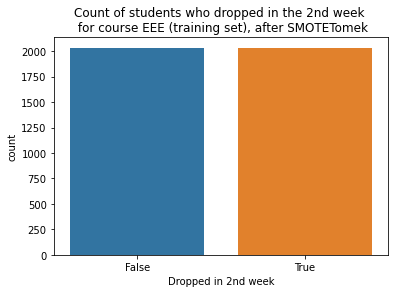

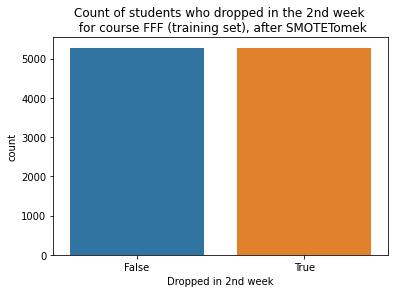

In [19]:
# Visualize resampled distribution
for module, code in zip(resampled_xy_train, module_codes):
    ax = sns.countplot(x ='dropped_in_week_of_interest', data=module[1].to_frame())
    plt.title(str('Count of students who dropped in the 2nd week \n for course ' + code + ' (training set), after SMOTETomek'))
    plt.xlabel('Dropped in 2nd week')
    plt.show()

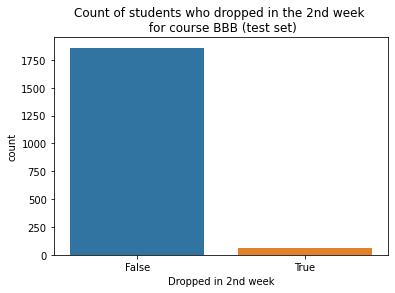

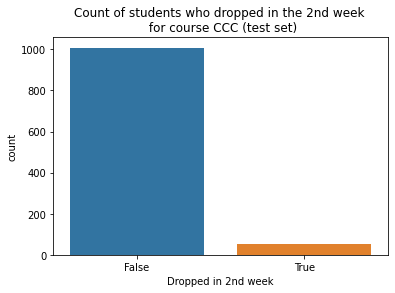

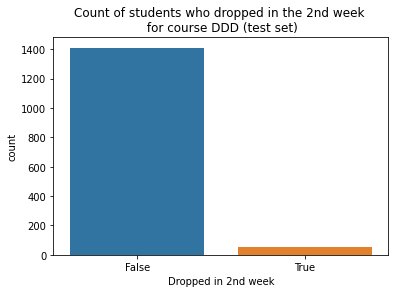

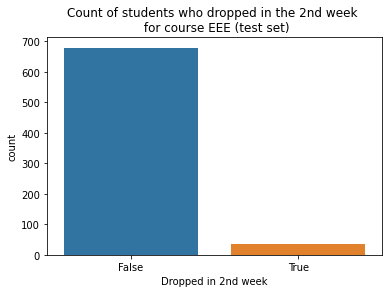

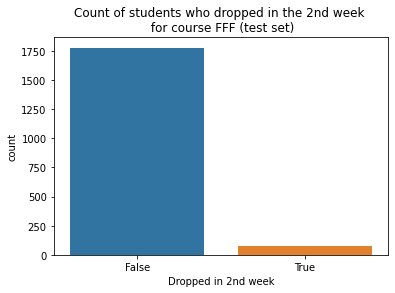

In [20]:
# Prepare and visualize test data
xy_test = []

for module in student_activity_features_test:
    X = module.drop(columns = ['id_student','dropped_in_week_of_interest']).reset_index(drop = True)
    Y = module['dropped_in_week_of_interest'].reset_index(drop = True).astype('bool')
    
    xy_test.append([X,Y])
    
for module, code in zip(xy_test, module_codes):
    ax = sns.countplot(x ='dropped_in_week_of_interest', data=module[1].to_frame())
    plt.title(str('Count of students who dropped in the 2nd week \n for course ' + code + ' (test set)'))
    plt.xlabel('Dropped in 2nd week')
    plt.show()

# Test Different Models 
Predict if a student will drop in the 2nd week (target variable) based on their first week's activity records (features). Evalute the performance of different models for each course.

In [21]:
# scale input data
from sklearn.preprocessing import StandardScaler

train_test_data = []
scalers = []

for train, test in zip(resampled_xy_train, xy_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[0])
    Y_train = train[1]
    X_test = scaler.transform(test[0])
    Y_test = test[1]
    scalers.append(scaler)
    
    train_test_data.append([X_train, X_test, Y_train, Y_test])

In [22]:
# function to plot ROC curves for different machine learning models
# https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, roc_auc_score

# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(max_iter = 1000, random_state=1234), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=1234),
               RandomForestClassifier(random_state=1234)]

def try_models(X_train, X_test, Y_train, Y_test, code):
    # Define a result table as a DataFrame
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

    # Train the models and record the results
    for cls in classifiers:
        model = cls.fit(X_train, Y_train)
        yproba = model.predict_proba(X_test)[::,1]

        fpr, tpr, _ = roc_curve(Y_test,  yproba)
        auc = roc_auc_score(Y_test, yproba)

        result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)

    #-------------------------------------------------------------------------

    fig = plt.figure(figsize=(8,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title(str('ROC Curve Analysis for Course ' + code), fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

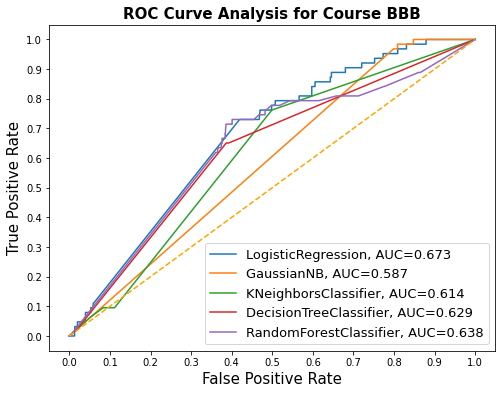

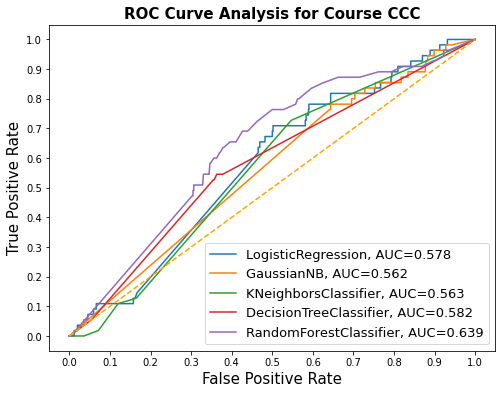

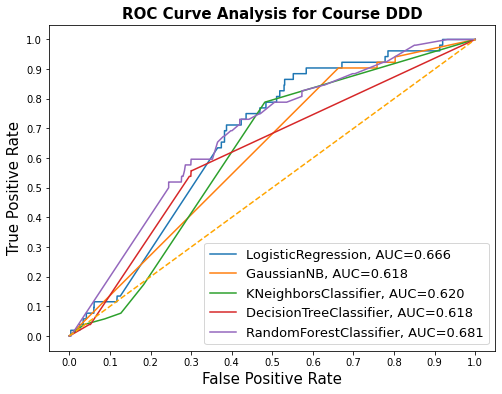

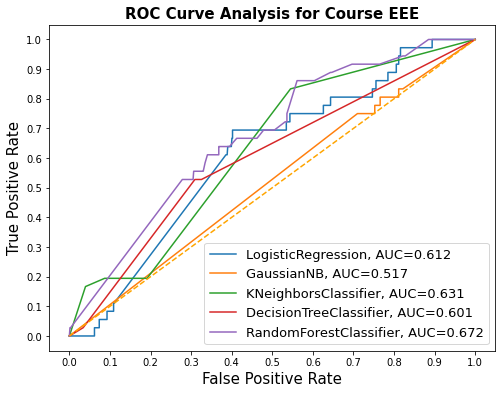

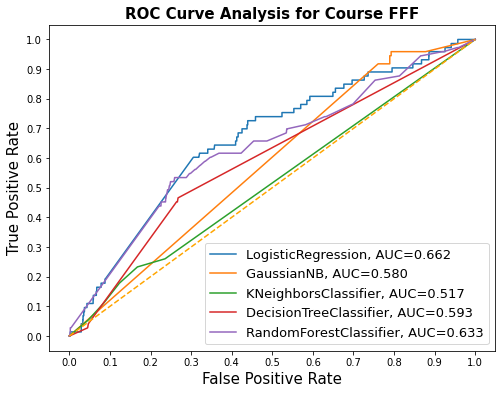

In [23]:
for module, code in zip(train_test_data, module_codes):
    try_models(module[0], module[1], module[2], module[3], code)

**Observation:**
- Based on the ROC curve analysis, we learned that the Random Forest classifier produced the largest AUC for 3 out of 5 courses, and the 2nd largest AUG for the other 2 coures, falling a little bit lower than the AUC for logistic regression. Overall, the Random Forest classifier showed some potential for the classification task at hand.

# Hyperparameter Tuning on Random Forest Classifier
Stage 1: <br>
- Randomized hyperparameter search with 2-fold CV is first used to narrow down the search by randoming testing 50 combinations of hyperparemeters. 

Stage 2: <br>
- Grid search with 10-fold CV is used to further fine-tune the hyperparameters around the best set of hyperparameters obtained from Stage 1.
- 10-fold CV is used to prevent overfitting.

Note on choice of performance metric: <br>
- Due to class imbalance in the test set, using accuracy as the performance meteric can be misleading. 
- Here, we choose to focus on **recall**. Namely, we focus on the true positive rate.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

# Number of trees in random forest
n_estimators = [50, 100, 150, 200]
# Maximum number of levels in tree
max_depth =  [10, 50, 100, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

best_rand = []

for module in train_test_data:
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 2, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(module[0], module[2])
    print(rf_random.best_params_)
    
    best_rand.append(rf_random.best_estimator_)
    predictions = rf_random.best_estimator_.predict(module[1])
    
    TN = confusion_matrix(module[3], predictions.astype('bool'))[0][0]
    FP = confusion_matrix(module[3], predictions.astype('bool'))[0][1]
    FN = confusion_matrix(module[3], predictions.astype('bool'))[1][0]
    TP = confusion_matrix(module[3], predictions.astype('bool'))[1][1]

    total = TN + FP + FN + TP
    acc = (TP + TN) / float(total)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)

    print ('Model Accuracy: {} Recall:{} Precision:{}'.format(round(acc,2), round(recall,2), round(precision,2)))

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.6s finished


{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50}
Model Accuracy: 0.63 Recall:0.62 Precision:0.05
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.2s finished


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50}
Model Accuracy: 0.68 Recall:0.47 Precision:0.08
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.0s finished


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50}
Model Accuracy: 0.74 Recall:0.52 Precision:0.07
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.8s finished


{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50}
Model Accuracy: 0.71 Recall:0.53 Precision:0.09
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.3s finished


{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50}
Model Accuracy: 0.76 Recall:0.44 Precision:0.07


The results above are in the order of Course BBB, CCC, DDD, EEE, FFF.

In [26]:
best_rand

[RandomForestClassifier(max_depth=50, n_estimators=150),
 RandomForestClassifier(max_depth=50, n_estimators=200),
 RandomForestClassifier(max_depth=50, n_estimators=200),
 RandomForestClassifier(max_depth=50, n_estimators=150),
 RandomForestClassifier(max_depth=50, n_estimators=150)]

In [27]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [40, 50, 60],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [125, 150, 175, 200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

best_grid = []

for module in train_test_data:   
    
    grid_search.fit(module[0], module[2])
    print(grid_search.best_params_)
    
    best_grid.append(grid_search.best_estimator_)
    predictions = grid_search.best_estimator_.predict(module[1])
    
    TN = confusion_matrix(module[3], predictions.astype('bool'))[0][0]
    FP = confusion_matrix(module[3], predictions.astype('bool'))[0][1]
    FN = confusion_matrix(module[3], predictions.astype('bool'))[1][0]
    TP = confusion_matrix(module[3], predictions.astype('bool'))[1][1]

    total = TN + FP + FN + TP
    acc = (TP + TN) / float(total)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)

    print ('Model Accuracy: {} Recall:{} Precision:{}'.format(round(acc,2), round(recall,2), round(precision,2)))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  7.6min finished


{'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 150}
Model Accuracy: 0.63 Recall:0.62 Precision:0.05
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.8min finished


{'max_depth': 40, 'min_samples_split': 4, 'n_estimators': 125}
Model Accuracy: 0.68 Recall:0.47 Precision:0.08
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.5min finished


{'max_depth': 50, 'min_samples_split': 3, 'n_estimators': 175}
Model Accuracy: 0.74 Recall:0.52 Precision:0.07
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.4min finished


{'max_depth': 40, 'min_samples_split': 3, 'n_estimators': 175}
Model Accuracy: 0.71 Recall:0.53 Precision:0.09
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


{'max_depth': 60, 'min_samples_split': 2, 'n_estimators': 125}
Model Accuracy: 0.76 Recall:0.45 Precision:0.08


In [28]:
best_grid

[RandomForestClassifier(max_depth=50, n_estimators=150),
 RandomForestClassifier(max_depth=40, min_samples_split=4, n_estimators=125),
 RandomForestClassifier(max_depth=50, min_samples_split=3, n_estimators=175),
 RandomForestClassifier(max_depth=40, min_samples_split=3, n_estimators=175),
 RandomForestClassifier(max_depth=60, n_estimators=125)]

In [129]:
feature_importance = []
recall_mem = []
size_mem = []
for count, module in enumerate(train_test_data):

    test_predictions = best_grid[count].predict(module[1])
    TN = confusion_matrix(module[3], test_predictions.astype('bool'))[0][0]
    FP = confusion_matrix(module[3], test_predictions.astype('bool'))[0][1]
    FN = confusion_matrix(module[3], test_predictions.astype('bool'))[1][0]
    TP = confusion_matrix(module[3], test_predictions.astype('bool'))[1][1]

    size_mem.append(module[3].shape[0])
    
    total = TN + FP + FN + TP
    acc = (TP + TN) / float(total)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    recall_mem.append(recall)
    print ('Test Accuracy: {} Recall:{}'.format(round(acc,2), round(recall,2)))
    
    feature_importance.append(pd.DataFrame({'Variable':xy_test[count][0].columns,
              'Importance':best_grid[count].feature_importances_}))

Test Accuracy: 0.63 Recall:0.62
Test Accuracy: 0.68 Recall:0.47
Test Accuracy: 0.74 Recall:0.52
Test Accuracy: 0.71 Recall:0.53
Test Accuracy: 0.76 Recall:0.45


The results above are in the order of Course BBB, CCC, DDD, EEE, FFF.

# Visualize Feature Importance

Visualize importance of features for each course. Each grid of heatmap represents a feature, and the colour of the grid represents its importance. For example, the colour of the top left grid in the first figure represents the importance of a student's interaction with the course homepage (y-axis) on day 1 (x-axis).

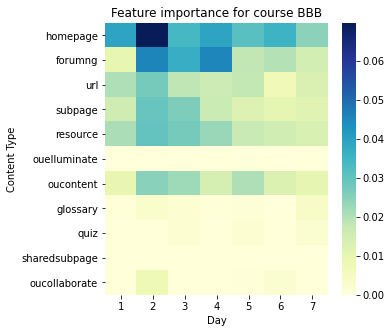

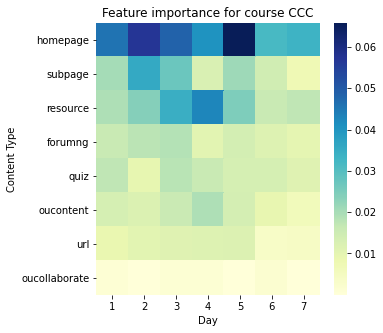

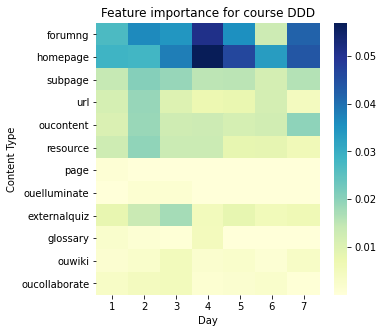

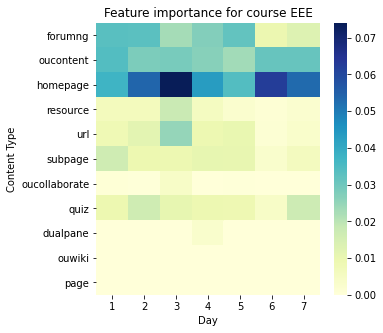

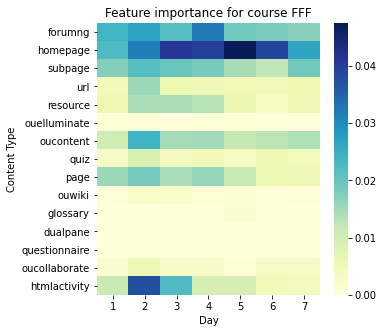

In [133]:
for module, code in zip(feature_importance, module_codes):
    num_of_activities = int(module.shape[0]/7)
    y_axis_labels = [act[:-1] for act in module.Variable[0::7].to_numpy()]
    x_axis_labels = list(range(1,7+1))
    fig = plt.figure(figsize=(5,5))
    sns.heatmap(module.Importance.to_numpy().reshape(num_of_activities,7),  xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="YlGnBu")
    plt.title(str('Feature importance for course ' + code))
    plt.xlabel('Day')
    plt.ylabel('Content Type')
    plt.show()

**Observation:**
- For all the courses, homepage activity carry the most importance in the first week.

# Visualize relationship between homepage activity in week 1 and the tendency to drop in week 2

Based on the analysis in the last section, homepage activities are the most important features. Here, we visualize the relationship between between homepage activity in week 1 and the tendency to drop in week 2 (target variable). 

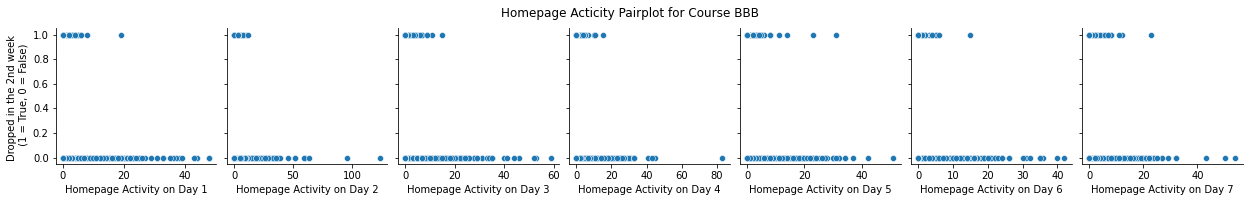

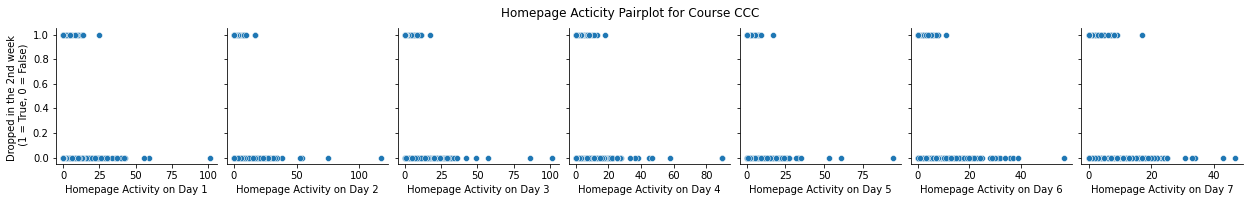

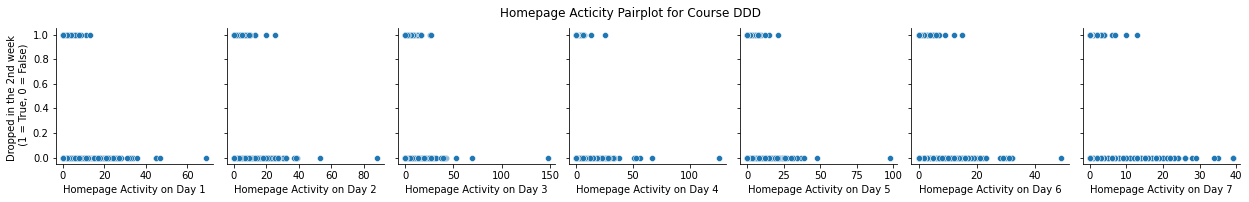

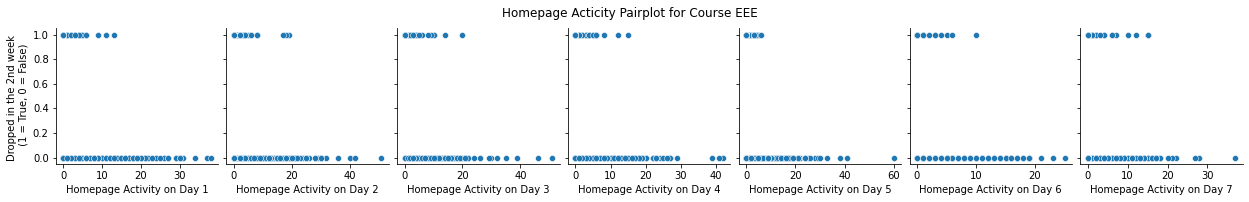

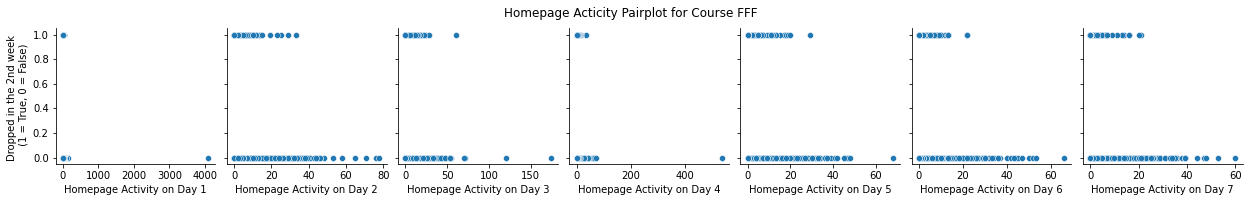

In [31]:
x_names = [str('Homepage Activity on Day ' + str(day)) for day in list(range(1,8))]
y_name = 'Dropped in the 2nd week \n (1 = True, 0 = False)'
for module, code in zip(student_activity_features, module_codes):
    pp = sns.pairplot(module, kind = 'scatter', x_vars = ['homepage0', 'homepage1', 'homepage2', 'homepage3', 'homepage4', 'homepage5', 'homepage6'], 
                 y_vars = ['dropped_in_week_of_interest'], diag_kind = None)
    pp.fig.suptitle(str('Homepage Acticity Pairplot for Course ' + code), y=1.08)
    pp.axes[0][0].set_ylabel(y_name)
    for i, feature in enumerate(x_names):
        pp.axes[0][i].set_xlabel(x_names[i])
    
    plt.show()

**Observation:**
- Those who dropped in the second week (y axis = 1), tend to have very little interaction with course homepage in the first week.

# Compare average click counts for those who dropped and those who didn't drop

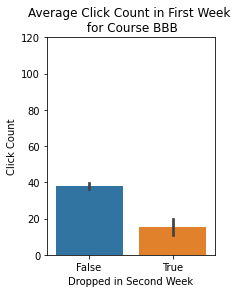

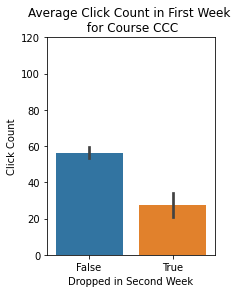

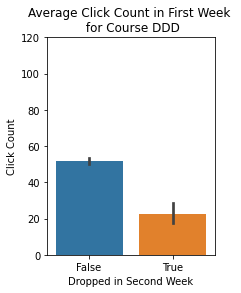

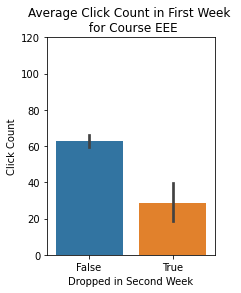

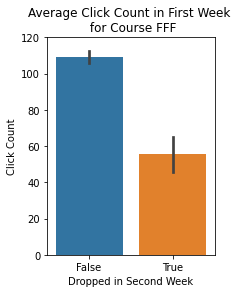

In [126]:
for module, code in zip(student_activity_features, module_codes):
    
    fig, ax = plt.subplots(figsize=(3,4))
    
    act = module.drop(columns = ['id_student'])
    flag = act.dropped_in_week_of_interest
    act = act.drop(columns = ['dropped_in_week_of_interest']).T.sum()
    course = pd.Series([code]*act.shape[0])
    graph_data_temp = pd.concat([flag, act], axis = 1)
    sns.barplot(ax=ax, x="dropped_in_week_of_interest", y=0, data=graph_data_temp)
    plt.title(str('Average Click Count in First Week \n for Course ' + code))
    plt.ylabel('Click Count')
    plt.xlabel('Dropped in Second Week')
    plt.ylim([0,120])
    plt.savefig(str(code+'.png'))
    plt.show()
    #break

**Observation:**
- Students who dropped in the second week tend to have less interaction than those who didn't dropped. This is consistent across all the courses analyzed.

# Summary of Key Points

- Students who drop courses in the beginning of the term tend to have very little interaction/activity with the online learning platform in the week before dropping the course. 
- Out of all the content categories (course homepage, course forum, resources, ect.), how much a student interacts with the course homepage in the first week tells us the most about whether he/she will drop in the following week.
- Using student activity records in week 1, our model correctly identifies 51.6% of students  (on average, across 5 courses) who will unregister in week 2.  

Overall, student activity records do carry some information that indicates student interest, but the main weakness of this approach is the over-simplification of student behavior. For example, students who downloaded the course content to their local machines would not generate any activity data. Moreover, there are many factors that determine student retention other than their interest in the course content -- financial considerations, program credit limit, and time conflicts, to name a few.
